# Network Traffic Forecasting (using time series data)

In telco, accurate forecast of KPIs (e.g. network traffic, utilizations, user experience, etc.) for communication networks ( 2G/3G/4G/5G/wired) can help predict network failures, allocate resource, or save energy. 

In this notebook, we demonstrate a reference use case where we use the network traffic KPI(s) in the past to predict traffic KPI(s) in the future. We demostrate how to do **univariate forecasting** (predict only 1 series), and **multivariate forecasting** (predicts more than 1 series at the same time) using Project Chronos.

For demonstration, we use the publicly available network traffic data repository maintained by the [WIDE project](http://mawi.wide.ad.jp/mawi/) and in particular, the network traffic traces aggregated every 2 hours (i.e. AverageRate in Mbps/Gbps and Total Bytes) in year 2018 and 2019 at the transit link of WIDE to the upstream ISP ([dataset link](http://mawi.wide.ad.jp/~agurim/dataset/)). 

## Helper functions

This section defines some helper functions to be used in the following procedures. You can refer to it later when they're used.

In [1]:
def plot_predict_actual_values(date, y_pred, y_test, ylabel):
    """
    plot the predicted values and actual values (for the test data)
    """
    fig, axs = plt.subplots(figsize=(16,6))

    axs.plot(date, y_pred, color='red', label='predicted values')
    axs.plot(date, y_test, color='blue', label='actual values')
    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel('test datetime')
    plt.ylabel(ylabel)
    plt.legend(loc='upper left')
    plt.show()

## Download raw dataset and load into dataframe

Now we download the dataset and load it into a pandas dataframe. Steps are as below. 

* First, run the script `get_data.sh` to download the raw data. It will download the monthly aggregated traffic data in year 2018 and 2019 into `data` folder. The raw data contains aggregated network traffic (average MBPs and total bytes) as well as other metrics. 

* Second, run `extract_data.sh` to extract relavant traffic KPI's from raw data, i.e. `AvgRate` for average use rate, and `total` for total bytes. The script will extract the KPI's with timestamps into `data/data.csv`.

* Finally, use pandas to load `data/data.csv` into a dataframe as shown below

In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
raw_df = pd.read_csv("data/data.csv")

Below are some example records of the data

In [4]:
raw_df.head()

,StartTime,EndTime,AvgRate,total
0,2018/01/01 00:00:00,2018/01/01 02:00:00,306.23Mbps,275605455598
1,2018/01/01 02:00:00,2018/01/01 04:00:00,285.03Mbps,256527692256
2,2018/01/01 04:00:00,2018/01/01 06:00:00,247.39Mbps,222652190823
3,2018/01/01 06:00:00,2018/01/01 08:00:00,211.55Mbps,190396029658
4,2018/01/01 08:00:00,2018/01/01 10:00:00,234.82Mbps,211340468977


## Data pre-processing

Now we need to do data cleaning and preprocessing on the raw data. Note that this part could vary for different dataset. 

For the network traffic data we're using, the processing contains 2 parts:
1. Convert string datetime to TimeStamp
2. Unify the measurement scale for `AvgRate` value - some uses Mbps, some uses Gbps 

In [5]:
df = pd.DataFrame(pd.to_datetime(raw_df.StartTime))

# we can find 'AvgRate' is of two scales: 'Mbps' and 'Gbps'
raw_df.AvgRate.str[-4:].unique() 

# Unify AvgRate value
df['AvgRate'] = raw_df.AvgRate.apply(lambda x:float(x[:-4]) if x.endswith("Mbps") else float(x[:-4])*1000)

df["total"] = raw_df["total"]

In [6]:
df.head()

,StartTime,AvgRate,total
0,2018-01-01 00:00:00,306.23,275605455598
1,2018-01-01 02:00:00,285.03,256527692256
2,2018-01-01 04:00:00,247.39,222652190823
3,2018-01-01 06:00:00,211.55,190396029658
4,2018-01-01 08:00:00,234.82,211340468977


Plot the data to see how the KPI's look like

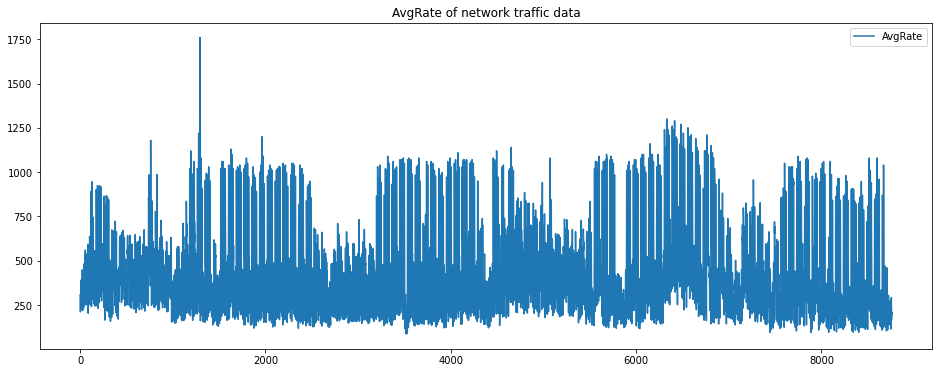

In [7]:
ax = df.plot(y='AvgRate',figsize=(16,6), title="AvgRate of network traffic data")

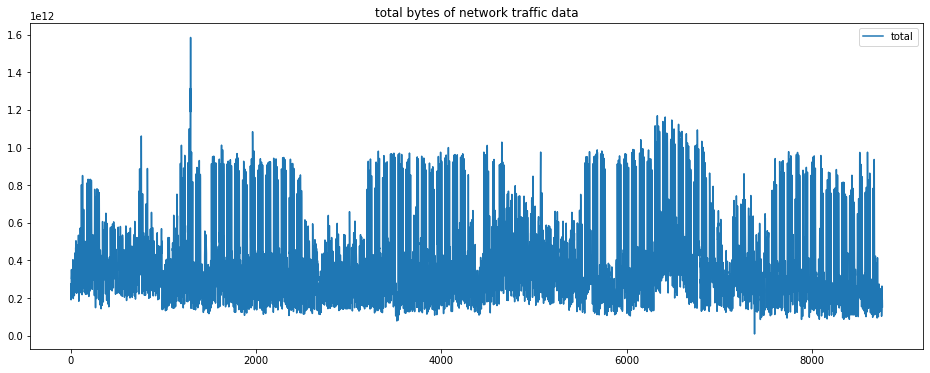

In [8]:
ax = df.plot(y='total',figsize=(16,6), title="total bytes of network traffic data")

## Feature Engineering & Data Preperation

For feature engineering, we use year, month, week, day of week and hour as features in addition to the target KPI values.

For data preperation, we impute the data to handle missing data and scale the data.

We generate a built-in TSDataset to complete the whole processing.

In [9]:
from zoo.chronos.data import TSDataset
from sklearn.preprocessing import StandardScaler

# we look back one week data which is of the frequency of 2h.
look_back = 84
# specify the number of steps to be predicted，one day is selected by default.
horizon = 1

In [10]:
tsdata_train, _, tsdata_test = TSDataset.from_pandas(df, dt_col="StartTime", target_col=["AvgRate","total"], with_split=True, test_ratio=0.1)
standard_scaler = StandardScaler()
for tsdata in [tsdata_train, tsdata_test]:
    tsdata.gen_dt_feature()\
          .impute(mode="last")\
          .scale(standard_scaler, fit=(tsdata is tsdata_train))

# Time series forecasting 

### Univariate forecasting

For _univariate_ forecasting, we forecast ``AvgRate`` only. We need to roll the data on corresponding target column with tsdataset. 

In [11]:
for tsdata in [tsdata_train, tsdata_test]:
    tsdata.roll(lookback=look_back, horizon=horizon, feature_col = ["MONTH(StartTime)", "WEEKOFYEAR(StartTime)", "WEEKDAY(StartTime)", "HOUR(StartTime)"], target_col="AvgRate")
    
x_train, y_train = tsdata_train.to_numpy()
x_test, y_test = tsdata_test.to_numpy()
y_train, y_test = y_train[:, 0, :], y_test[:, 0, :]
x_train.shape, y_train.shape, x_test.shape, y_test.shape    

((7800, 84, 5), (7800, 1), (792, 84, 5), (792, 1))

For univariate forcasting, we use LSTMForecaster for forecasting.

In [12]:
from zoo.chronos.model.forecast.lstm_forecaster import LSTMForecaster

First we initiate a LSTMForecaster. 
* `feature_dim` should match the training data input feature, so we just use the last dimension of train data shape. 
* `target_dim` equals the variate num we want to predict. We set target_dim=1 for univariate forecasting.

In [13]:
# build model
lstm_config = {"lstm_units": [32] * 2, "lr":0.001}
forecaster = LSTMForecaster(target_dim=1, feature_dim=x_train.shape[-1], **lstm_config)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Then we use fit to train the model. Wait sometime for it to finish.

In [14]:
%%time
forecaster.fit(x=x_train, y=y_train, batch_size=1024, epochs=50, distributed=False)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 7800 samples
Epoch 1/50
7800/7800 [==============================] - 3s 323us/sample - loss: 1.0312 - mean_squared_error: 1.0312
Epoch 2/50
7800/7800 [==============================] - 2s 261us/sample - loss: 0.9383 - mean_squared_error: 0.9383
Epoch 3/50
7800/7800 [==============================] - 2s 272us/sample - loss: 0.8696 - mean_squared_error: 0.8696
Epoch 4/50
7800/7800 [==============================] - 2s 280us/sample - loss: 0.8117 - mean_squared_error: 0.8117
Epoch 5/50
7800/7800 [==============================] - 2s 287us/sample - loss: 0.7333 - mean_squared_error: 0.7333
Epoch 6/50
7800/7800 [==============================] - 2s 296us/sample - loss: 0.6369 - mean_squared_error: 0.6369
Epoch 7/50
7800/7800 [==============================] - 2s 292us/sample - loss: 0.5060 - mean_squared_error: 0.5060
Epoch 8/50
7800/7800 [==============================] - 3s 351us/sample 

After training is finished. You can use the forecaster to do prediction and evaluation.

In [15]:
# make prediction
y_pred = forecaster.predict(x_test)

Since we have used standard scaler to scale the input data (including the target values), we need to inverse the scaling on the predicted values too. 

In [16]:
y_pred_unscale = tsdata_test.unscale_numpy(np.expand_dims(y_pred, axis=1))[:, 0, :]
y_test_unscale = tsdata_test.unscale_numpy(np.expand_dims(y_test, axis=1))[:, 0, :]

calculate the symetric mean absolute percentage error.

In [17]:
from zoo.automl.common.metrics import Evaluator
# evaluate with sMAPE
print("sMAPE is", Evaluator.evaluate("smape", y_test_unscale, y_pred_unscale))
# evaluate with mean_squared_error
print("mean_squared error is", Evaluator.evaluate("mse", y_test_unscale, y_pred_unscale))

sMAPE is [10.80624134]
mean_squared error is [7625.18484685]


### multivariate forecasting 

For _multivariate_ forecasting, we forecast `AvgRate` and `total` at the same time. We need to roll the data on corresponding target column with tsdataset. 

In [18]:
for tsdata in [tsdata_train, tsdata_test]:
    tsdata.roll(lookback=look_back, horizon=horizon, feature_col = ["MONTH(StartTime)", "WEEKOFYEAR(StartTime)", "WEEKDAY(StartTime)", "HOUR(StartTime)"], target_col=["AvgRate","total"])
    
x_train_m, y_train_m = tsdata_train.to_numpy()
x_test_m, y_test_m = tsdata_test.to_numpy()
y_train_m, y_test_m = y_train_m[:, 0, :], y_test_m[:, 0, :]
x_train_m.shape, y_train_m.shape, x_test_m.shape, y_test_m.shape

((7800, 84, 6), (7800, 2), (792, 84, 6), (792, 2))

For multivariate forecasting, we use MTNetForecaster for forecasting. 

In [19]:
from zoo.chronos.model.forecast.mtnet_forecaster import MTNetForecaster

First, we initialize a mtnet_forecaster according to input data shape. The lookback length is equal to `(long_series_num+1)*series_length` Details refer to [chronos docs](https://github.com/intel-analytics/analytics-zoo/tree/master/pyzoo/zoo/chronos).

In [20]:
mtnet_forecaster = MTNetForecaster(target_dim=y_train_m.shape[-1],
                        feature_dim=x_train_m.shape[-1],
                        long_series_num=6,
                        series_length=12,
                        ar_window_size=6,
                        cnn_height=4
    )

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


MTNet needs to preprocess the X into another format, so we call `MTNetForecaster.preprocess_input` on train_x and test_x.

In [21]:
# mtnet requires reshape of input x before feeding into model.
x_train_mtnet = mtnet_forecaster.preprocess_input(x_train_m)
x_test_mtnet = mtnet_forecaster.preprocess_input(x_test_m)

Now we train the model and wait till it finished. 

In [22]:
%%time
hist = mtnet_forecaster.fit(x = x_train_mtnet, y = y_train_m, batch_size=1024, epochs=20)

Train on 7800 samples
Epoch 1/20
7800/7800 [==============================] - 35s 5ms/sample - loss: 0.9341 - mean_squared_error: 1.3602
Epoch 2/20
7800/7800 [==============================] - 38s 5ms/sample - loss: 0.8357 - mean_squared_error: 1.2013
Epoch 3/20
7800/7800 [==============================] - 55s 7ms/sample - loss: 0.7573 - mean_squared_error: 1.1149
Epoch 4/20
7800/7800 [==============================] - 63s 8ms/sample - loss: 0.6917 - mean_squared_error: 0.9659
Epoch 5/20
7800/7800 [==============================] - 63s 8ms/sample - loss: 0.6308 - mean_squared_error: 0.8516
Epoch 6/20
7800/7800 [==============================] - 61s 8ms/sample - loss: 0.5759 - mean_squared_error: 0.7433
Epoch 7/20
7800/7800 [==============================] - 65s 8ms/sample - loss: 0.5339 - mean_squared_error: 0.6459
Epoch 8/20
7800/7800 [==============================] - 62s 8ms/sample - loss: 0.5022 - mean_squared_error: 0.5602
Epoch 9/20
7800/7800 [==============================] - 78

Use the model for prediction and inverse the scaling of the prediction results

In [23]:
y_pred_m = mtnet_forecaster.predict(x_test_mtnet)

In [24]:
y_pred_m_unscale = tsdata_test.unscale_numpy(np.expand_dims(y_pred_m, axis=1))[:, 0, :]
y_test_m_unscale = tsdata_test.unscale_numpy(np.expand_dims(y_test_m, axis=1))[:, 0, :]

In [25]:
from zoo.automl.common.metrics import Evaluator
# evaluate with sMAPE
print("sMAPE is", Evaluator.evaluate("smape", y_test_m_unscale, y_pred_m_unscale, multioutput="raw_values"))
# evaluate with mean_squared_error
print("mean_squared error is", Evaluator.evaluate("mse", y_test_m_unscale, y_pred_m_unscale, multioutput="raw_values"))

sMAPE is [10.92461981  9.34126258]
mean_squared error is [6.43837165e+03 5.09000315e+21]


plot actual and prediction values for `AvgRate` KPI

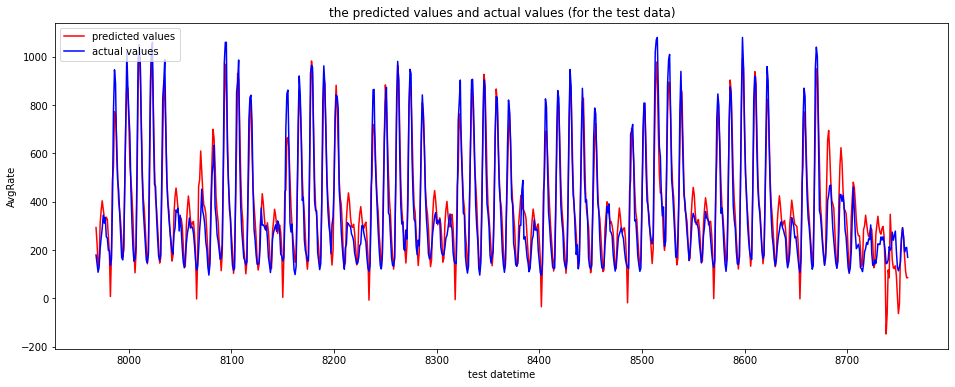

In [26]:
multi_target_value = ["AvgRate","total"]
test_date=df[-y_test_m_unscale.shape[0]:].index
plot_predict_actual_values(test_date, y_pred_m_unscale[:,0], y_test_m_unscale[:,0], ylabel=multi_target_value[0])

plot actual and prediction values for `total bytes` KPI

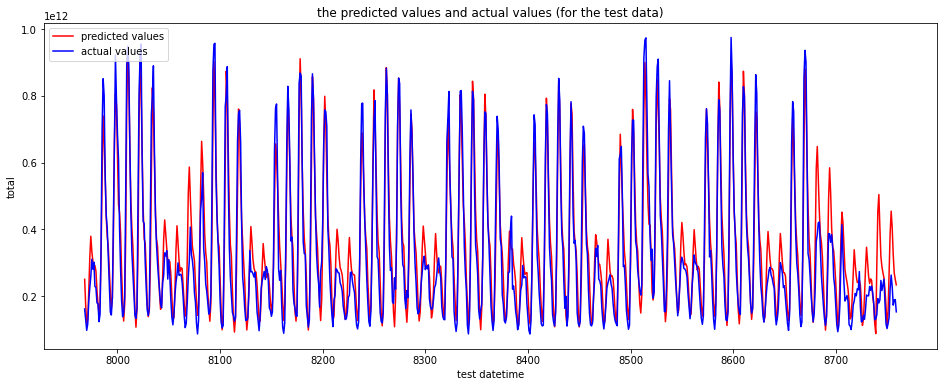

In [27]:
plot_predict_actual_values(test_date, y_pred_m_unscale[:,1], y_test_m_unscale[:,1], ylabel=multi_target_value[1])